In [1]:
from optimization_func import simulated_annealing
from helper import mse, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
import multiprocessing as mp
from workers import vary_T_worker
t, P = get_predator_prey_data()
import shelve


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

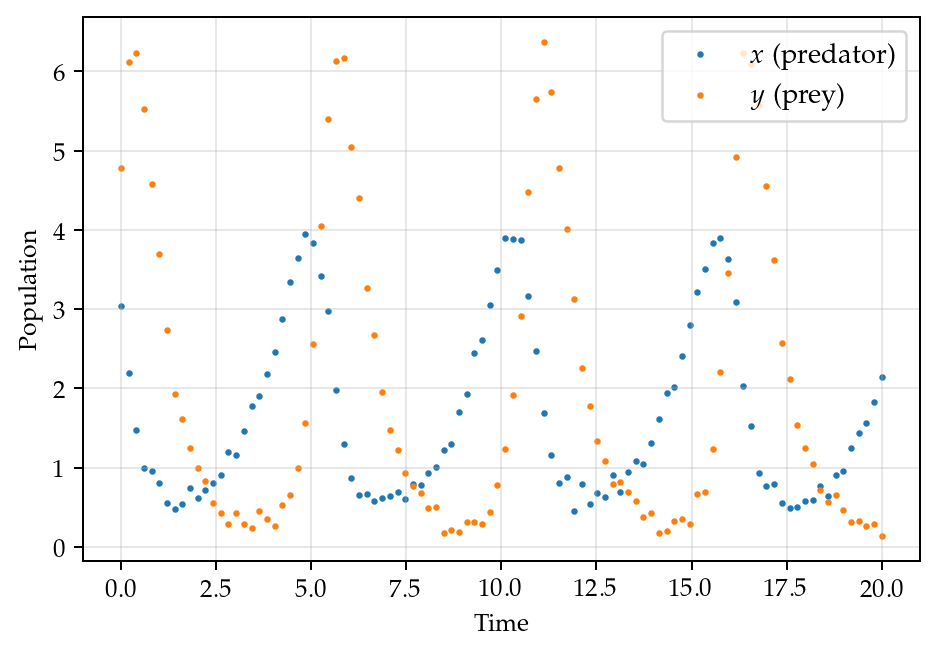

In [4]:
#plt.plot(t, z[0], label="$x$ fit", alpha=0.7)
#plt.plot(t, z[1], label="$y$ fit", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("figures/data_points.pdf", bbox_inches="tight")
plt.show()

# Parameter Tuning

### Cooling schedules visualization

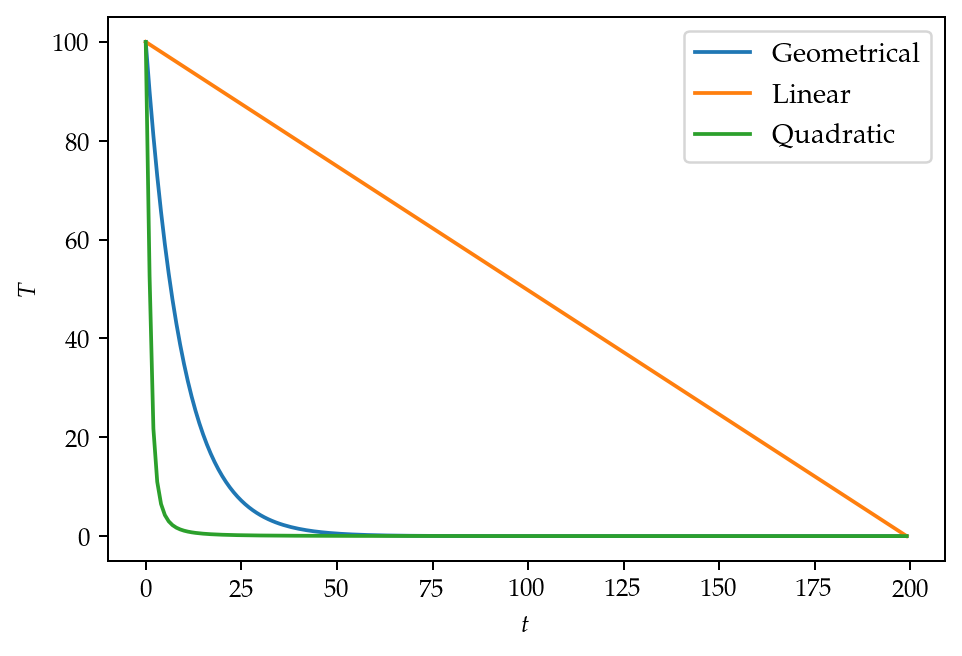

In [21]:
T_start = 100
T_steps = 200
alpha = 0.9

T_sched_geo =  [T_start*alpha**k for k in range(T_steps)]
T_sched_lin = np.linspace(T_start, 1e-5, T_steps)
T_sched_quad = [T_start/(1 + alpha*k**2) for k in range(T_steps)]


plt.plot(T_sched_geo, label="Geometrical")
plt.plot(T_sched_lin, label="Linear")
plt.plot(T_sched_quad, label = "Quadratic")
plt.legend()
plt.ylabel("$T$")
plt.xlabel("$t$")
plt.savefig("figures/cooling_schedules.pdf", bbox_inches="tight")
plt.show()

### Choice Of T0 (start Temperature)

In [9]:
def generate_initial_temperature(Ts, n=20):
    s0s = np.random.uniform(low=0.5, high=4, size=(5, 4))
    ratio_means = []
    ratio_stdevs = []
    
    for T in Ts:
        accepted_ratios = []
        for s0 in s0s:
            for i in range(n):
                _, accepted_ratio = simulated_annealing(s0, t, P, T_start=T, T_steps=200, alpha=1)
                accepted_ratios.append(accepted_ratio)
        ratio_means.append(np.mean(accepted_ratios))
        ratio_stdevs.append(np.std(accepted_ratios))
            
    return np.array(ratio_means), np.array(ratio_stdevs)

In [10]:
if False:
    shelf = shelve.open("Arrays/t0_parameter")
    
    Ts = np.linspace(1, 1000, 20, dtype=int)
    np.random.seed(111)
    ratio_means, ratio_stdevs = generate_initial_temperature(Ts)

    shelf["means"] = ratio_means
    shelf["stdevs"] = ratio_stdevs
    shelf.close()

In [11]:
shelf = shelve.open("Arrays/t0_parameter")
ratio_means, ratio_stdevs = shelf["means"], shelf["stdevs"]
shelf.close()

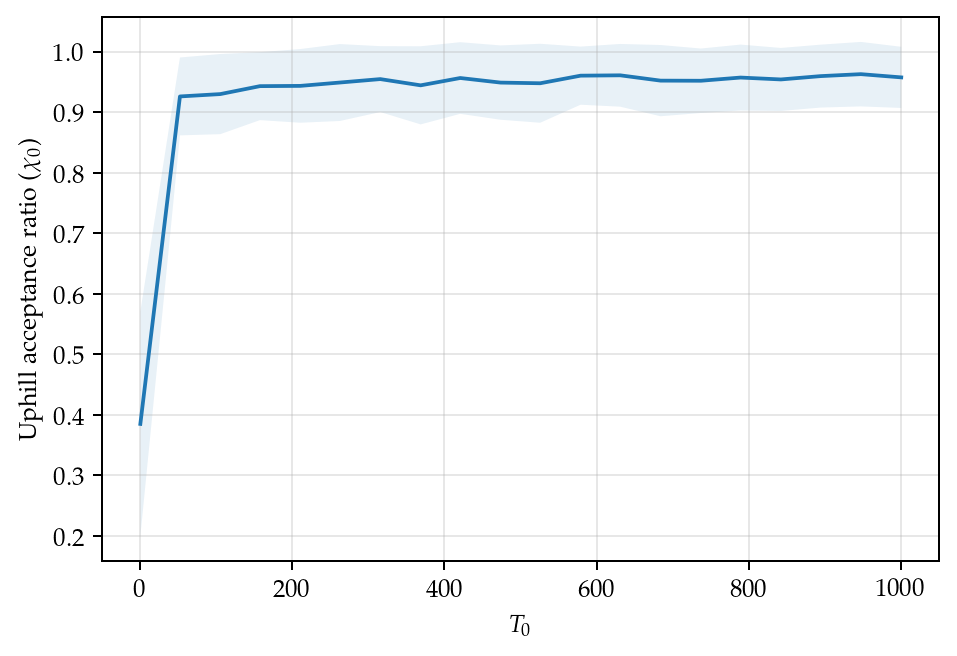

In [18]:
Ts = np.linspace(1, 1000, 20, dtype=int)
plt.plot(Ts, ratio_means)
plt.fill_between(Ts, ratio_means - ratio_stdevs, ratio_means + ratio_stdevs, alpha=0.1)
#plt.ylim(0.5, 1.05)
plt.xlabel("$T_0$")
plt.ylabel("Uphill acceptance ratio ($\\chi_0$)")
plt.grid(alpha=0.3)
plt.savefig("figures/t0_acceptance_ratio.pdf", bbox_inches="tight")
plt.show()

### Choice of T steps (iterations)

In [13]:
def rvs_generator(n_rv = 10):
    return np.random.uniform(low=0.5, high=2, size=(n_rv,4))


def Vary_T_steps(cooling_schedule, rvs, n_sim = 10, T_start = 200):
    T_steps_range = np.linspace(100, 10000, 20, dtype=int) 
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(T_steps_range)):
        results.append(manager.list())
        for _ in range(n_sim):
            for rv in rvs:
                work_queue.put((T_steps_range[i], i, rv))

    processes = []

    for i in range(8):
        p = mp.Process(target=vary_T_worker, args=(
            work_queue, results, T_start, t, P, cooling_schedule
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], T_steps_range


In [ ]:
%%time
np.random.seed(692304)
rvs = rvs_generator(n_rv = 5)

if True: 
    shelf = shelve.open("Arrays/T_parameter")
    T_vary_geo, T_steps_range = Vary_T_steps(cooling_schedule="geometrical", rvs=rvs)
    shelf["T_vary_geo"] = T_vary_geo
    shelf["T_steps_range"] = T_steps_range
    
    T_vary_lin, _ = Vary_T_steps(cooling_schedule="linear", rvs=rvs)
    shelf["T_vary_lin"] = T_vary_lin
    
    T_vary_quad, _ = Vary_T_steps(cooling_schedule="Quadratic", rvs=rvs)
    shelf["T_vary_quad"] = T_vary_quad
    
    shelf.close() 

In [6]:
shelf = shelve.open("Arrays/T_parameter")
Test = shelf["T_vary_geo"]
shelf.close()

In [20]:

print(np.mean(T_vary_geo, axis = 1))
print(np.median(T_vary_geo, axis = 1))
print(np.min(T_vary_geo, axis = 1))
print(np.max(T_vary_geo, axis = 1))

[5.60075962 4.24385737 3.34095007 3.74447696 3.43007281 3.26023204
 2.7565198  3.63904006 2.84304793 2.22864602 2.8182548  2.68522671
 2.65319584 2.44745696 2.70348973 2.40490434 1.79827542 1.25027383
 1.72951844 2.25586921]
[6.96907209 5.94487177 0.58178918 5.69113939 5.72855962 2.98880785
 0.07326079 5.6789019  0.0539273  0.05358178 0.13590797 0.04294778
 0.05201558 0.0496866  0.07406657 0.05304614 0.02956644 0.02599487
 0.02616324 0.03639071]
[0.37663069 0.05141837 0.02947294 0.02750339 0.027326   0.02102081
 0.01877099 0.01710536 0.01771842 0.01805046 0.01852986 0.01876464
 0.01922668 0.01970902 0.01870954 0.01777749 0.01778833 0.01894576
 0.01796401 0.01858054]
[9.95622196 8.31542406 9.30919899 8.24337385 7.70966522 8.23731844
 8.20207301 8.2173197  7.41555218 8.22433486 8.21294532 8.18311422
 8.22139338 8.23203699 8.24502586 8.24201548 8.66627029 8.23589418
 8.23513226 8.23693092]
Wall time: 2.99 ms


# Solution Testing and plotting

In [4]:
#np.random.seed(1212)
s0 = [1, 1, 0.21, 1]
print(int_cost_lotka_volterra(s0, P, t, cost=mse))
x, _, _ = simulated_annealing(s0, t, P, T_start=200, T_steps=5000)

57.42093030482687


In [45]:
print(x)

[0.28930072 0.2710766  1.24012772 2.12110726]


5.753957867163961


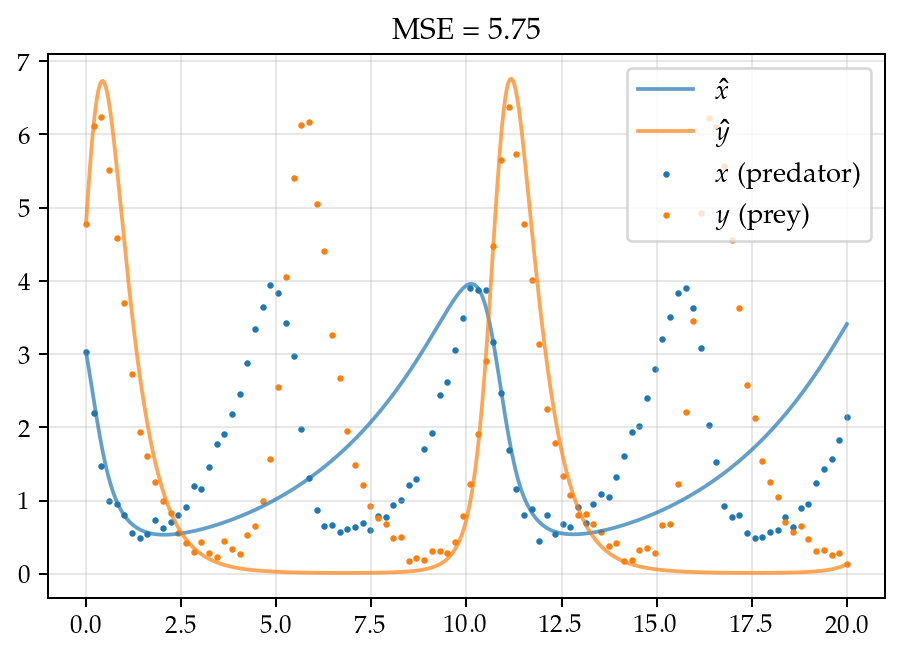

In [46]:
from scipy.integrate import solve_ivp
import numpy as np

sol_opt = solve_ivp(lotka_volterra, (t[0], t[-1]), P[0], args=x, dense_output=True)
z_opt = sol_opt.sol(t)
ts = np.linspace(t[0], t[-1], 500)
z_opt_smooth = sol_opt.sol(ts)

mse_ = mse(P, z_opt.T)
print(mse_)

plt.plot(ts, z_opt_smooth[0], label="$\\hat{x}$", alpha=0.7)
plt.plot(ts, z_opt_smooth[1], label="$\\hat{y}$", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.title(f"MSE = ${mse_:.2f}$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()